# Trénovanie modelu iba na základe DST indexu 24h dopredu 6 dozadu
Súbor: 3_model_lstm_iba_dst.ipynb

Program: Hospodárska informatika

Vypracovala: Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

### Kontrola kapacity servera

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Import knižníc

In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report

2022-10-23 19:55:03.740545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-23 19:55:03.740602: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-23 19:55:03.834065: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-23 19:55:05.734424: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-23 19:55:05.734560: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [4]:
df = pd.read_csv('omni_full.csv')
len(df)

520443

In [5]:
df.columns

Index(['Unnamed: 0', 'time1', 'Rot$', 'IMF', 'PLS', 'IMF_PTS', 'PLS_PTS',
       'ABS_B', 'F', 'THETA_AV', 'PHI_AV', 'BX_GSE', 'BY_GSE', 'BZ_GSE',
       'BY_GSM', 'BZ_GSM', 'SIGMA$ABS_B', 'SIGMA$B', 'SIGMA$Bx', 'SIGMA$By',
       'SIGMA$Bz', 'T', 'N', 'V', 'PHI$V', 'THETA$V', 'Ratio', 'Pressure',
       'SIGMA$T', 'SIGMA$N', 'SIGMA$V', 'SIGMA$PHI$V', 'SIGMA$THETA$V',
       'SIGMA$ratio', 'E', 'Beta', 'Mach_num', 'Mgs_mach_num', 'PR$FLX_1',
       'PR$FLX_2', 'PR$FLX_4', 'PR$FLX_10', 'PR$FLX_30', 'PR$FLX_60', 'MFLX',
       'R', 'F10_INDEX', 'KP', 'DST', 'AE', 'AP_INDEX', 'AL_INDEX', 'AU_INDEX',
       'PC_N_INDEX', 'Solar_Lyman_alpha', 'Proton_QI', 'DST+1', 'DST+2',
       'DST+3', 'DST+4', 'DST+6', 'DST+8', 'DST+12', 'DST+24'],
      dtype='object')

In [6]:
features = ['time1',
           'DST',
            'DST+24']

In [7]:
df = df[features]

In [8]:
df['time1']=pd.to_datetime(df['time1'])

In [9]:
df.dropna(inplace=True)
print(len(df))

520419


In [10]:
predicted_label = 'DST+24'

In [11]:
df.describe()

,DST,DST+24
count,520419.000000,520419.000000
mean,-14.125264,-14.126064
std,22.035288,22.034785
min,-589.000000,-589.000000
25%,-22.000000,-22.000000
50%,-10.000000,-10.000000
75%,-1.000000,-1.000000
max,81.000000,81.000000


In [12]:
df[predicted_label].describe()

count    520419.000000
mean        -14.126064
std          22.034785
min        -589.000000
25%         -22.000000
50%         -10.000000
75%          -1.000000
max          81.000000
Name: DST+24, dtype: float64

In [13]:
df.head()

,time1,DST,DST+24
24,1963-01-02 01:00:00,-9.0,-5.0
25,1963-01-02 02:00:00,-7.0,-5.0
26,1963-01-02 03:00:00,-5.0,-3.0
27,1963-01-02 04:00:00,-5.0,-3.0
28,1963-01-02 05:00:00,-4.0,-6.0


<AxesSubplot:>

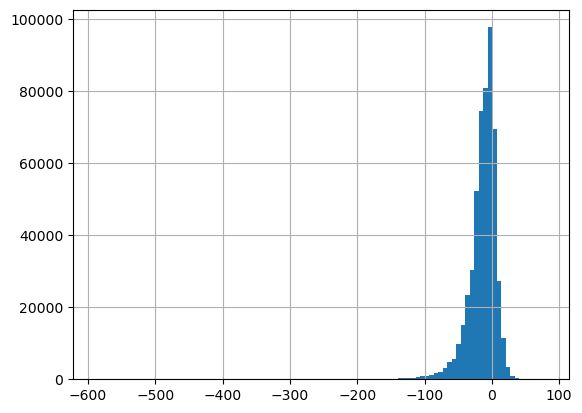

In [14]:
df[predicted_label].hist(bins=100)

In [15]:
# transform label using sigmoid
variance = df[predicted_label].std()
df["contcontinuous_transforminuous_transform"] = df[predicted_label].apply(lambda x: expit(2 * ((x - 0.2) / variance)))
df["contcontinuous_transforminuous_transform"].describe()

count    5.204190e+05
mean     3.113535e-01
std      2.271121e-01
min      5.947456e-24
25%      1.176374e-01
50%      2.837758e-01
75%      4.727972e-01
max      9.993474e-01
Name: contcontinuous_transforminuous_transform, dtype: float64

In [16]:
# choose one of them
# define y variable, i.e., what we want to predict

y_col='DST+24'
#y_col='contcontinuous_transforminuous_transform'

In [17]:
# train-test division

test_size = int(len(df) * 0.2) # here I ask that the test data will be 20% of the entire data
train = df.iloc[:-test_size,:].copy()
test = df.iloc[-test_size:,:].copy()

In [18]:
# train-validation division

valid_size = int(len(train) * 0.2) # here I ask that the test data will be 15% of the entire data
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

In [19]:
# separate features and labels

y_train = train[y_col].values.copy()
X_train = train['DST'].values.copy()

y_val = valid[y_col].values.copy()
X_val = valid['DST'].values.copy()

y_test = test[y_col].values.copy()
X_test = test['DST'].values.copy()

In [20]:
print(y_test[0:40])

[-12.  -9.  -9.  -8.  -6.  -7. -11.  -8.  -7.  -5.  -6.  -6.  -5.  -4.
  -7.  -9.  -9. -12. -13. -13. -12. -12. -17. -17. -15. -11.  -8. -12.
 -16. -14. -14. -14. -15. -17. -13. -15. -24. -21. -17. -15.]


In [21]:
len(y_test)

104083

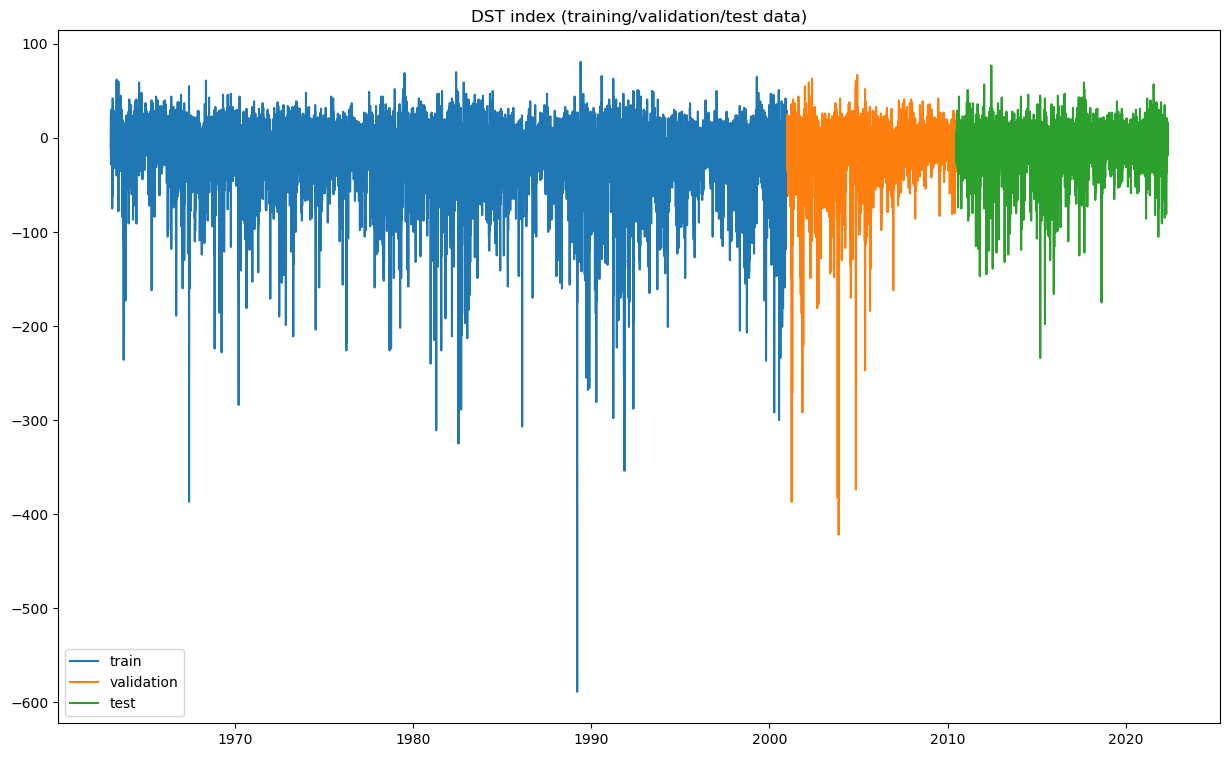

In [22]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [23]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [24]:
for i in range(len(test_generator)):
	x, y = test_generator[i]
	print('tt %s => %s' % (x, y))

tt [[-15. -11.  -8. -12. -16. -14.]
 [-11.  -8. -12. -16. -14. -14.]
 [ -8. -12. -16. -14. -14. -14.]
 ...
 [ -6.  -4.  -5.  -8. -10.  -9.]
 [ -4.  -5.  -8. -10.  -9. -11.]
 [ -5.  -8. -10.  -9. -11. -12.]] => [-11.  -8.  -7.  -5.  -6.  -6.  -5.  -4.  -7.  -9.  -9. -12. -13. -13.
 -12. -12. -17. -17. -15. -11.  -8. -12. -16. -14. -14. -14. -15. -17.
 -13. -15. -24. -21. -17. -15. -17. -25. -27. -26. -27. -27. -25. -26.
 -20. -16. -14. -14. -16. -16. -15. -13. -10. -15. -18. -21. -22. -18.
 -14. -15. -18. -19. -19. -16. -16. -17. -17. -15. -18. -15. -13. -12.
 -10. -14. -16. -16. -12. -10.  -9.  -9. -13. -17. -16. -21. -21. -19.
 -19. -17. -17. -19. -18. -19. -18. -16. -16. -16. -16. -14. -11.  -7.
  -6. -11. -19. -22. -21. -18. -15. -13. -15. -13. -13. -12. -12.  -9.
 -10. -11. -14. -13. -12.  -8.  -4.  -1.  -1.  -1.  -4.  -6.  -9. -12.
 -12. -15. -19. -21. -18. -16. -12. -12. -11. -12. -15. -17. -17. -15.
 -14. -13.  -9.  -8.  -9.  -9.  -8.  -5.  -3.  -5.  -7.  -9. -12. -10.
 -11. -12

In [25]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1302
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [26]:
inputs = Input(shape=(n_input,1))
b = Conv1D(128, kernel_size = 4, padding = "same")(inputs)
b = Bidirectional(LSTM(128, dropout=0.1,recurrent_dropout=0.1))(inputs)
b = Dense(64, activation='relu')(b)
b = Dropout(0.2)(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2022-10-23 19:55:32.990851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-23 19:55:32.991646: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-23 19:55:32.991748: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              133120    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                             

In [27]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 256)           133120    
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 7   

In [28]:
# callbacks
saved_model = "6_dozadu_24_dopredu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [29]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20
1302/1302 [==============================] - ETA: 0s - loss: 342.0943 - mae: 11.7921
Epoch 1: val_mae improved from inf to 10.10604, saving model to 6_dozadu_24_dopredu.hdf5
1302/1302 [==============================] - 170s 120ms/step - loss: 342.0943 - mae: 11.7921 - val_loss: 299.4428 - val_mae: 10.1060
Epoch 2/20
1302/1302 [==============================] - ETA: 0s - loss: 326.8468 - mae: 11.5663
Epoch 2: val_mae improved from 10.10604 to 9.87730, saving model to 6_dozadu_24_dopredu.hdf5
1302/1302 [==============================] - 186s 143ms/step - loss: 326.8468 - mae: 11.5663 - val_loss: 281.1915 - val_mae: 9.8773
Epoch 3/20
1302/1302 [==============================] - ETA: 0s - loss: 322.2310 - mae: 11.4828
Epoch 3: val_mae did not improve from 9.87730
1302/1302 [==============================] - 187s 143ms/step - loss: 322.2310 - mae: 11.4828 - val_loss: 288.9661 - val_mae: 9.9120
Epoch 4/20
1302/1302 [==============================] - ETA: 0s - loss: 320.6561 - mae:

In [30]:
# load best model
model = keras.models.load_model('6_dozadu_24_dopredu.hdf5')

In [31]:
# prediction
y_pred = model.predict(test_generator)

407/407 [==============================] - 9s 19ms/step


In [32]:
y_pred

array([[-13.552006  ],
       [-13.646358  ],
       [-12.092886  ],
       ...,
       [  2.26118   ],
       [  1.495289  ],
       [  0.53881395]], dtype=float32)

In [33]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[77004  6357]
 [ 9981 10735]]


In [34]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     83361
           1       0.63      0.52      0.57     20716

    accuracy                           0.84    104077
   macro avg       0.76      0.72      0.74    104077
weighted avg       0.83      0.84      0.84    104077



In [35]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [36]:
df

,time,y_true,y_predict
416366,2010-06-29 16:00:00,-11.0,-13.552006
416367,2010-06-29 17:00:00,-8.0,-13.646358
416368,2010-06-29 18:00:00,-7.0,-12.092886
416369,2010-06-29 19:00:00,-5.0,-14.232906
416370,2010-06-29 20:00:00,-6.0,-17.411144
...,...,...,...
520438,2022-05-13 12:00:00,10.0,1.893888
520439,2022-05-13 13:00:00,9.0,1.476234
520440,2022-05-13 14:00:00,6.0,2.261180
520441,2022-05-13 15:00:00,6.0,1.495289


In [37]:
df.describe()

,y_true,y_predict
count,104077.000000,104077.000000
mean,-9.644994,-10.869929
std,16.038125,11.568502
min,-234.000000,-66.690697
25%,-17.000000,-15.720105
50%,-7.000000,-8.280661
75%,0.000000,-3.211311
max,77.000000,11.143762


<AxesSubplot:>

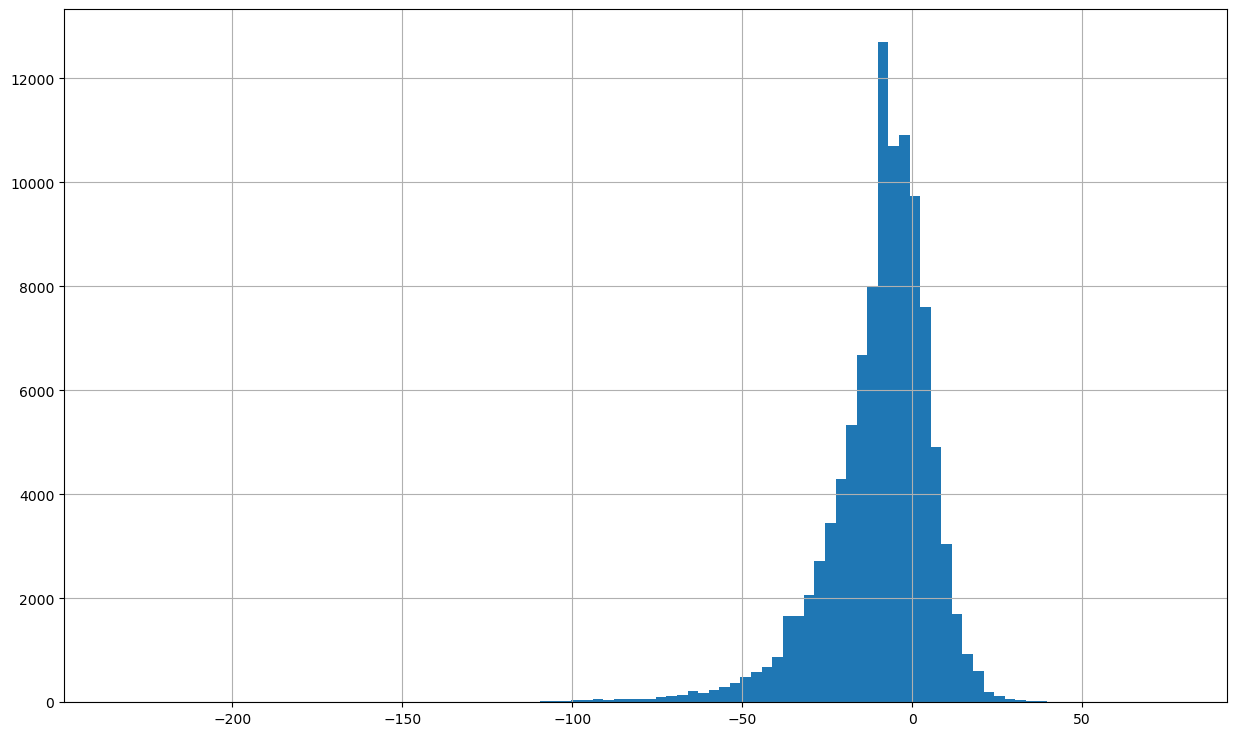

In [38]:
df["y_true"].hist(bins=100)

<AxesSubplot:>

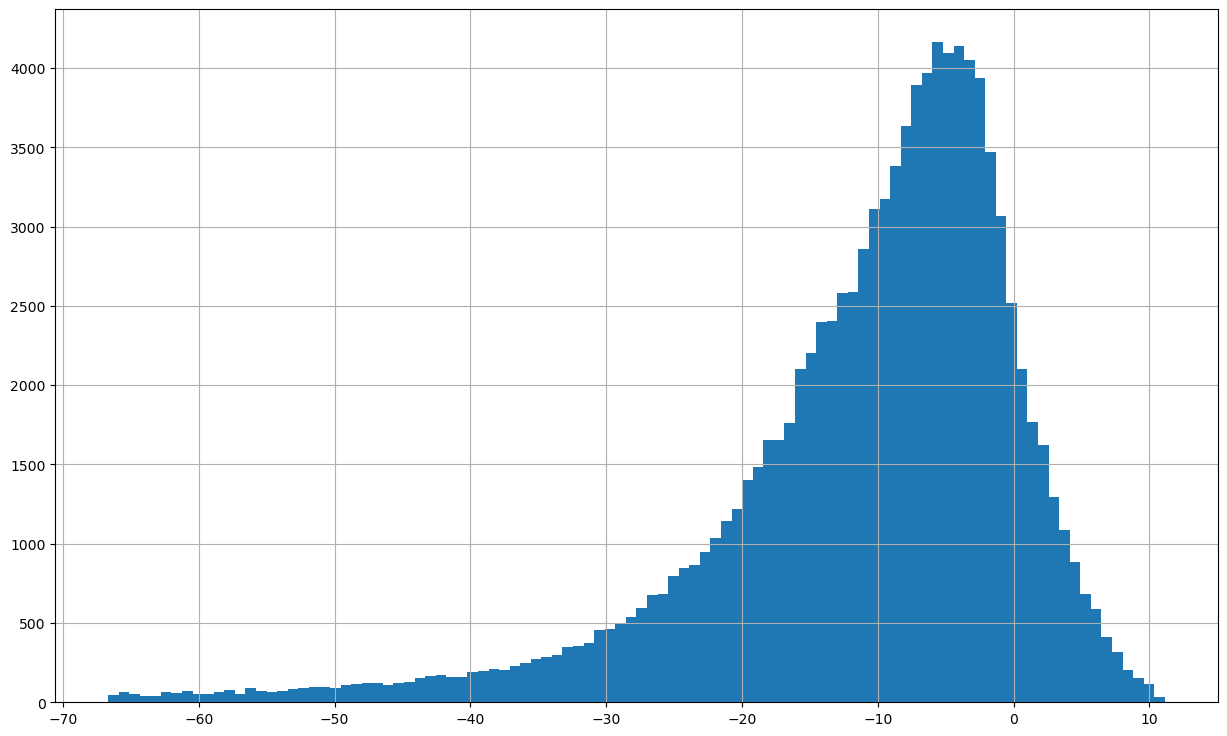

In [39]:
df["y_predict"].hist(bins=100)

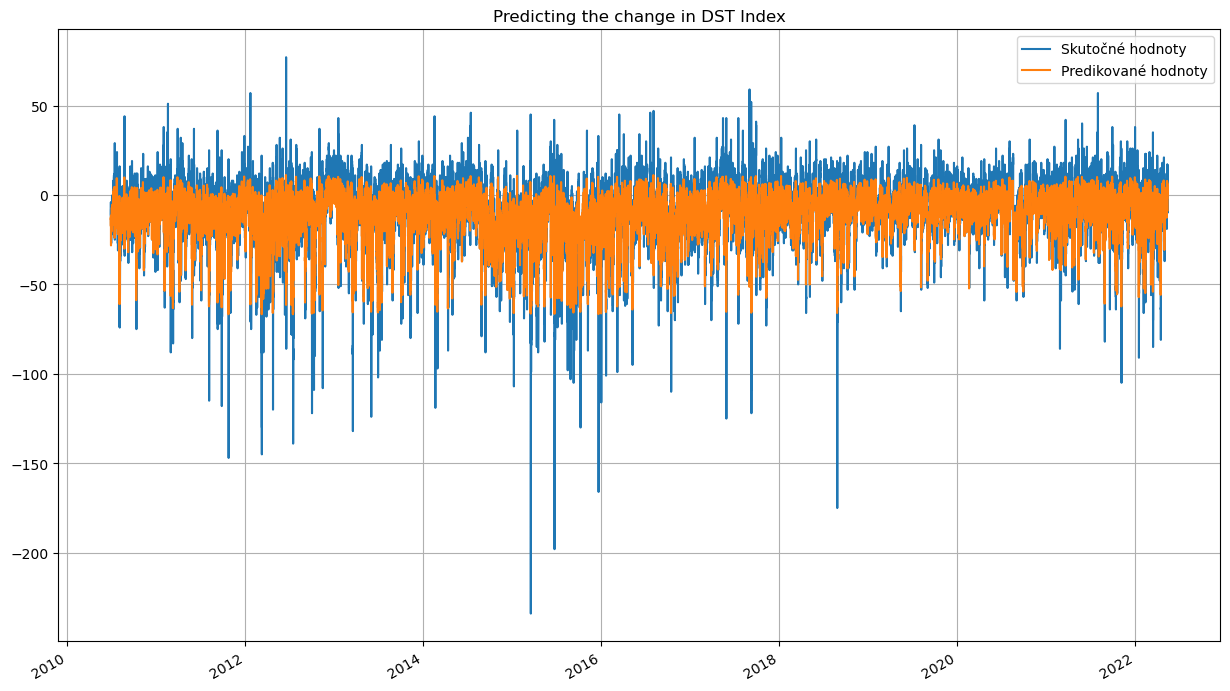

In [40]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [41]:
df.to_csv('predikcie_6h_dozadu_24h_dopredu.csv')